# 6233 Option Pricing and StochasticCalculus in Finance
# Final Project: Two Assets Correlation Options

### Conducted by: Chen, Yinqi He, Zicheng Quan, Shuning Zhang, Duanyang Zhang, Yaqian

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.integrate import dblquad,quad
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


## Analytical solution

### Pricing Option Value

In [ ]:
# Function to price option
def M(a,b,rho):
    """
    double intergral M in pricing
    
    """
    coef =  1/(2*np.pi*np.sqrt(1-rho**2))
    dbintergral = dblquad(lambda y,x:np.exp((-x**2 + 2*rho*x*y - y**2)/(2 - 2*rho**2)), ##f
                          -np.inf,       ## x lower bound
                          b,             ## x upper bound
                          -np.inf,       ## y lower bound
                          a)[0]          ## y upper bound
    return coef * dbintergral


def Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao): #定价方程
    """
    Payoff:max(S2(T)-K2,0) if S1(T)>K1  otherwise 0
    
    """
    y2 = (np.log(S2/K2) + (r - 1/2*sigma2**2) * tao) / (sigma2 * np.sqrt(tao))  # y2 = dz
    y1 = (np.log(S1/K1) + (r - 1/2*sigma1**2) * tao) / (sigma1 * np.sqrt(tao))  # y1 = dx
    V = S2 * M(y2 + sigma2*np.sqrt(tao), y1 + rho*sigma2*np.sqrt(tao), rho) - K2 * np.exp(-r*tao) * M(y2,y1,rho)
    return V

### Calculate Analytical Delta

In [16]:
## Analytical Delta
def dM1(a,b,S1,sigma1,rho,tao):
    f = lambda z: np.exp((-b**2 + 2*rho*b*z -z**2)/(2 - 2*rho**2)) / (sigma1 * np.sqrt(tao) * S1)
    dmds1 = quad(f, -np.inf, a)[0]/(2 * np.pi * (1-rho**2))
    return dmds1

def dM2(a,b,S2,sigma2,rho,tao):
    f = lambda x: np.exp((-a**2 + 2*rho*a*x -x**2)/(2 - 2*rho**2)) / (sigma2 * np.sqrt(tao) * S2)
    dmds2 = quad(f, -np.inf, b)[0]/(2 * np.pi * (1-rho**2))
    return dmds2
    

def Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao):
    dz = (np.log(S2/K2) + (r - 1/2*sigma2**2) * tao) / (sigma2 * np.sqrt(tao))
    dx = (np.log(S1/K1) + (r - 1/2*sigma1**2) * tao) / (sigma1 * np.sqrt(tao))
    A = dM1(dz + sigma2*np.sqrt(tao), dx  + rho*sigma2*np.sqrt(tao), S1, sigma1, rho, tao)
    B = dM1(dz, dx, S1, sigma1, rho, tao)
    D1 = S2 * A - K2 * np.exp(-r*tao) * B
    return D1

def Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao):
    dz = (np.log(S2/K2) + (r - 1/2*sigma2**2) * tao) / (sigma2 * np.sqrt(tao))
    dx = (np.log(S1/K1) + (r - 1/2*sigma1**2) * tao) / (sigma1 * np.sqrt(tao))
    C = dM2(dz + sigma2*np.sqrt(tao), dx  + rho*sigma2*np.sqrt(tao), S2, sigma2, rho, tao)
    D = dM2(dz, dx, S2, sigma2, rho, tao)
    D2 = M(dz+sigma2*np.sqrt(tao), dx+rho*sigma2*np.sqrt(tao), rho) + S2 * C - K2 * np.exp(-r*tao) * D
    return D2

### Analytical solution on real data

In [3]:
# Read data, change path here to load your own data
path1 = 'C:/Users/63438/Desktop/HP.csv'
path2 = 'C:/Users/63438/Desktop/DLTR.csv'

# Calculate annulized vol (sigma1,sigma2) and rho
df1 = pd.read_csv(path1,usecols=['Date','Close'],index_col=0).rename(columns={'Close': 'First'})
df1['firlogret']=np.log(df1.First) - np.log(df1.First.shift(1))
sigma1 = np.std(df1['firlogret'])*(252**0.5)

df2 = pd.read_csv(path2,usecols=['Date','Close'],index_col=0).rename(columns={'Close': 'Second'})
df2['seclogret']=np.log(df2.Second) - np.log(df2.Second.shift(1))
sigma2 = np.std(df2['seclogret'])*(252**0.5)

df = df1.merge(df2, left_index=True, right_index=True)
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]

# set up K, tao, r
K1, K2 = df['First'][0],df['Second'][0]
r = 0.0083
df['tao'] = range(252,0,-1) 
df['tao'] = df['tao'] /252

# Price option on each day's stocks price
df['OptionPrice'] = 0
for index, row in df.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao    
    df.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    


In [4]:
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice
Date,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,10.410965
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,10.624699
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,10.042789
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,9.856477
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,9.843518


In [5]:
# Delta From Analytics
df['Delta1'] = 0
df['Delta2'] = 0
for index, row in df.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao    
    df.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)

In [6]:
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2
Date,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,10.410965,0.167616,0.296651
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,10.624699,0.170831,0.299488
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,10.042789,0.177025,0.284728
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,9.856477,0.176792,0.281367
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,9.843518,0.173348,0.283304


In [7]:
# Delta From Numerics
df_num = df.copy()
df_num['NumDelta1'] = 0
df_num['NumDelta2'] = 0
chg = 0.1
for index, row in df_num.iterrows():
    S1 = row.First
    S1up = row.First + chg
    S1down = row.First - chg
    S2 = row.Second
    S2up = row.Second + chg
    S2down = row.Second - chg
    tao = row.tao  
    df_num.loc[index,'NumDelta1'] = (Pricing_Correlation_Option(S1up, S2, K1, K2, sigma1, sigma2, r, rho, tao) 
                           - Pricing_Correlation_Option(S1down, S2, K1, K2, sigma1, sigma2, r, rho, tao)) / (2 * chg)
    df_num.loc[index,'NumDelta2'] = (Pricing_Correlation_Option(S1, S2up, K1, K2, sigma1, sigma2, r, rho, tao) 
                           - Pricing_Correlation_Option(S1, S2down, K1, K2, sigma1, sigma2, r, rho, tao)) / (2 * chg)

In [8]:
df_num.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,NumDelta1,NumDelta2
Date,,,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,10.410965,0.167616,0.296651,0.155785,0.296651
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,10.624699,0.170831,0.299488,0.158773,0.299488
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,10.042789,0.177025,0.284728,0.164530,0.284728
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,9.856477,0.176792,0.281367,0.164313,0.281367
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,9.843518,0.173348,0.283304,0.161112,0.283304


## Validation process

### 1. Using monte carlo to validate prcing formula
### 2. Using Numerical Delta to validate Delta1 and Delta2 formula

### First, Fix K1, K2, Sigma, Sigma2 with S0_1 ∈(0, 200), S0_2 ∈（0, 200）

In [17]:
## Validation process:
### 1. Using monte carlo to validate prcing formula
### 2. Using Numerical Delta to validate Delta1 and Delta2 formula
def SimulateSP(sigma1,sigma2,T,S0_1,S0_2,r,delta,rho):
    stockprice1 = []
    stockprice2 = []
    stockprice1.append(S0_1)
    stockprice2.append(S0_2)
    S2 = S0_2
    S1 = S0_1
    for i in range(delta):
        w1 = np.random.normal(0,math.sqrt(T/delta))
        w2 = np.random.normal(0,math.sqrt(T/delta))
        w3 = rho*w1+np.sqrt(1-rho**2)*w2
        deltaprice1 = (r-0.5*sigma1**2)*(T/delta)+sigma1*w1
        deltaprice2 = (r-0.5*sigma2**2)*(T/delta)+sigma2*w3
        S1 = S1 * np.exp(deltaprice1)
        S2 = S2 * np.exp(deltaprice2)
        stockprice1.append(S1)
        stockprice2.append(S2)
    return stockprice1,stockprice2
         

def PricingByMc(K_1,K_2,r,T, s1, s2, sigma1, sigma2, rho):
    twoassetprice = []
    for i in range(5000):
        stockprice1,stockprice2 = SimulateSP(sigma1,sigma2,T,s1,s2,r,delta,rho)
        if stockprice1[-1] > K_1:
            twoassetprice.append(max(stockprice2[-1]-K_2,0)*np.exp(-r*T))
        else:
            twoassetprice.append(0)
    return np.mean(twoassetprice)

# Fix K1, K2, Sigma, Sigma2 with S0_1 ∈(0, 100), S0_2 ∈（0, 100）
K_1 = 95
K_2 = 90
r = 0.1
sigma_1 = 0.20
sigma_2 = 0.30
rho = 0.75
delta = 252
T =1
S0_1 = np.linspace(1, 200, 20)
S0_2 = np.linspace(200, 1, 20)
chu = 0.1

McPrices = []
AfPrices = []
NDelta1 = []
AfDelta1 = []
NDelta2 = []
AfDelta2 = []
for s2 in tqdm(S0_2):
    for s1 in S0_1:
        McPrices.append(PricingByMc(K_1,K_2,r,T, s1, s2, sigma_1, sigma_2, rho))
        AfPrices.append(Pricing_Correlation_Option(s1, s2, K_1, K_2, sigma_1, sigma_2, r, rho, T))
        NDelta1.append((Pricing_Correlation_Option(s1 + chu, s2, K_1, K_2, sigma_1, sigma_2, r, rho, T) - Pricing_Correlation_Option(s1 - chu, s2, K_1, K_2, sigma_1, sigma_2, r, rho, T)) / (2*chu))
        NDelta2.append((Pricing_Correlation_Option(s1, s2 + chu, K_1, K_2, sigma_1, sigma_2, r, rho, T) - Pricing_Correlation_Option(s1, s2 - chu, K_1, K_2, sigma_1, sigma_2, r, rho, T)) / (2*chu))
        AfDelta1.append(Delta1 (s1, s2, K_1, K_2, sigma_1, sigma_2, r, rho, T))
        AfDelta2.append(Delta2 (s1, s2, K_1, K_2, sigma_1, sigma_2, r, rho, T))
McPrices = np.array(McPrices).reshape(20,20)
AfPrices = np.array(AfPrices).reshape(20,20)
NDelta1 = np.array(NDelta1).reshape(20,20)
AfDelta1 = np.array(AfDelta1).reshape(20,20)
NDelta2 = np.array(NDelta2).reshape(20,20)
AfDelta2 = np.array(AfDelta2).reshape(20,20)






  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  5%|████                                                                            | 1/20 [04:28<1:24:57, 268.29s/it]

 10%|████████                                                                        | 2/20 [08:57<1:20:32, 268.45s/it]

 15%|████████████                                                                    | 3/20 [13:26<1:16:08, 268.71s/it]

 20%|████████████████                                                                | 4/20 [17:55<1:11:41, 268.84s/it]

 25%|████████████████████                                                            | 5/20 [22:27<1:07:25, 269.68s/it]

 30%|████████████████████████                                                        | 6/20 [26:57<1:02:57, 269.81s/it]

 35%|████████████████████████████▋                                                     | 7/20 [31:24<58:18, 269.10s/it]

 40%|█████████████████████████

### Plot

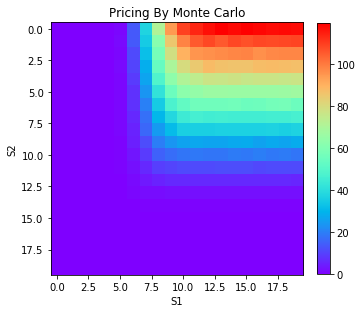

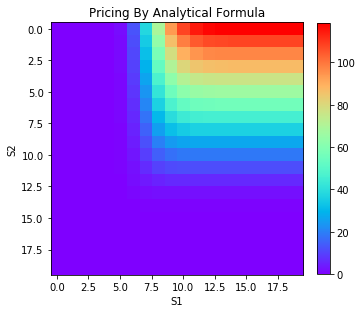

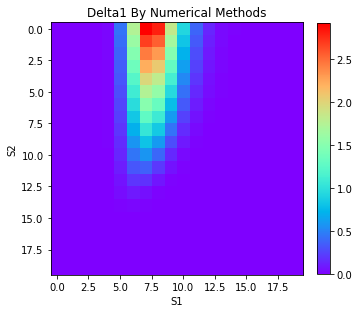

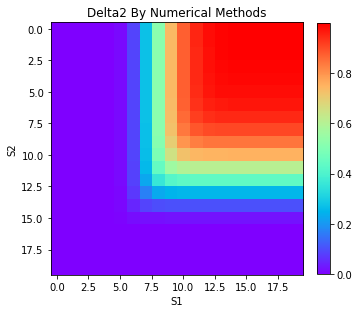

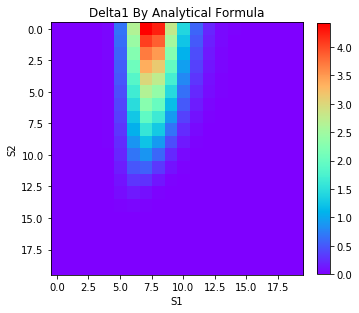

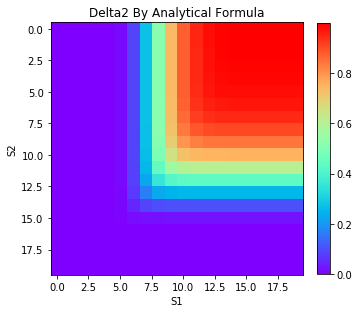

In [18]:
fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(McPrices, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
#ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Pricing By Monte Carlo", xlabel = "S1", ylabel = "S2")
plt.savefig("McPrices_1")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(AfPrices, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
#ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Pricing By Analytical Formula", xlabel = "S1", ylabel = "S2")
plt.savefig("AfPrices_1")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(NDelta1, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
#ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta1 By Numerical Methods", xlabel = "S1", ylabel = "S2")
plt.savefig("NDelta1_1")
    
fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(NDelta2, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
#ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta2 By Numerical Methods", xlabel = "S1", ylabel = "S2")
plt.savefig("NDelta2_1")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(AfDelta1, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
#ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta1 By Analytical Formula", xlabel = "S1", ylabel = "S2")
plt.savefig("AfDelta1_1")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(AfDelta2, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
#ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta2 By Analytical Formula", xlabel = "S1", ylabel = "S2")
plt.savefig("AfDelta2_1")

### Fix K1, K2, S0_1, S0_2 with sigma1 ∈(0, 1), sigma2 ∈（0, 1）

In [34]:
# Fix K1, K2, S0_1, S0_2 with sigma1 ∈(0, 1), sigma2 ∈（0, 1）
K_1 = 95
K_2 = 90
r = 0.1
sigma_1 = np.linspace(1,0.1, 100)
sigma_2 = np.linspace(0.1,1, 100)
rho = 0.75
delta = 252
T =1
S0_1 = 100
S0_2 = 100
chu = 0.1

McPrices = []
AfPrices = []
NDelta1 = []
AfDelta1 = []
NDelta2 = []
AfDelta2 = []
count = 1
for sg2 in sigma_2:
    for sg1 in sigma_1:
        print("Process: {:.2f}".format(count / 10000))
        count += 1
        McPrices.append(PricingByMc(K_1,K_2,r,T, S0_1, S0_2, sg1, sg2, rho))
        AfPrices.append(Pricing_Correlation_Option(S0_1, S0_2, K_1, K_1, sg1, sg2, r, rho, T))
        NDelta1.append((Pricing_Correlation_Option(S0_1 + chu, S0_2, K_1, K_2, sg1, sg2, r, rho, T) - Pricing_Correlation_Option(S0_1 - chu, S0_2, K_1, K_2, sg1, sg2, r, rho, T)) / (2*chu))
        NDelta2.append((Pricing_Correlation_Option(S0_1, S0_2 + chu, K_1, K_2, sg1, sg2, r, rho, T) - Pricing_Correlation_Option(S0_1, S0_2 - chu, K_1, K_2, sg1, sg2, r, rho, T)) / (2*chu))
        AfDelta1.append(Delta1 (S0_1, S0_2, K_1, K_2, sg1, sg2, r, rho, T))
        AfDelta2.append(Delta2 (S0_1, S0_2, K_1, K_2, sg1, sg2, r, rho, T))
McPrices = np.array(McPrices).reshape(100,100)
AfPrices = np.array(McPrices).reshape(100,100)
NDelta1 = np.array(McPrices).reshape(100,100)
AfDelta1 = np.array(McPrices).reshape(100,100)
NDelta2 = np.array(McPrices).reshape(100,100)
AfDelta2 = np.array(McPrices).reshape(100,100)

Process: 0.01
Process: 0.02
Process: 0.03
Process: 0.04
Process: 0.05
Process: 0.06
Process: 0.07
Process: 0.08
Process: 0.09
Process: 0.10
Process: 0.11
Process: 0.12
Process: 0.13
Process: 0.14
Process: 0.15
Process: 0.16
Process: 0.17
Process: 0.18
Process: 0.19
Process: 0.20
Process: 0.21
Process: 0.22
Process: 0.23
Process: 0.24
Process: 0.25
Process: 0.26
Process: 0.27
Process: 0.28
Process: 0.29
Process: 0.30
Process: 0.31
Process: 0.32
Process: 0.33
Process: 0.34
Process: 0.35
Process: 0.36
Process: 0.37
Process: 0.38
Process: 0.39
Process: 0.40
Process: 0.41
Process: 0.42
Process: 0.43
Process: 0.44
Process: 0.45
Process: 0.46
Process: 0.47
Process: 0.48
Process: 0.49
Process: 0.50
Process: 0.51
Process: 0.52
Process: 0.53
Process: 0.54
Process: 0.55
Process: 0.56
Process: 0.57
Process: 0.58
Process: 0.59
Process: 0.60
Process: 0.61
Process: 0.62
Process: 0.63
Process: 0.64
Process: 0.65
Process: 0.66
Process: 0.67
Process: 0.68
Process: 0.69
Process: 0.70
Process: 0.71
Proces

### Plot

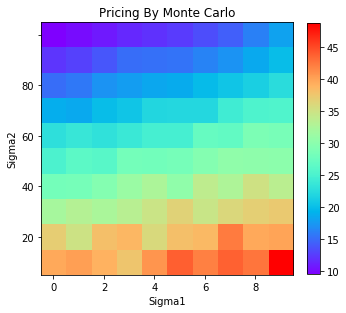

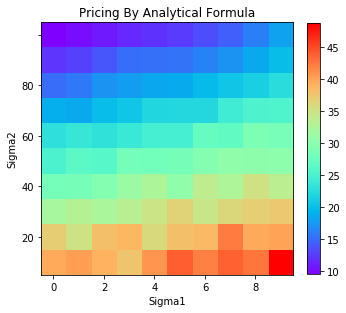

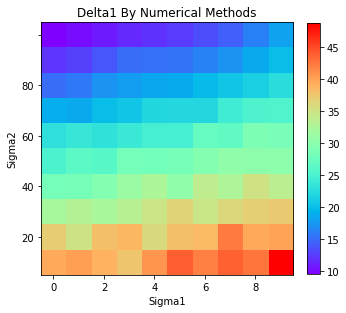

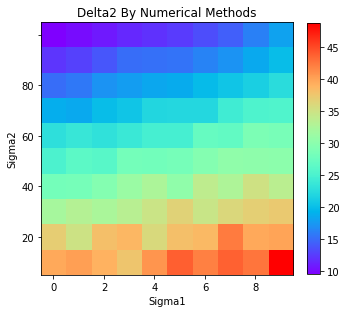

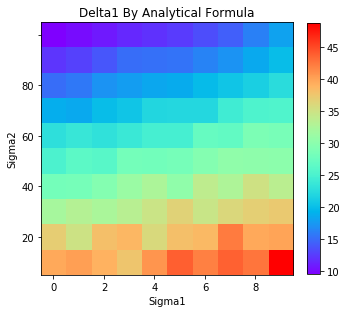

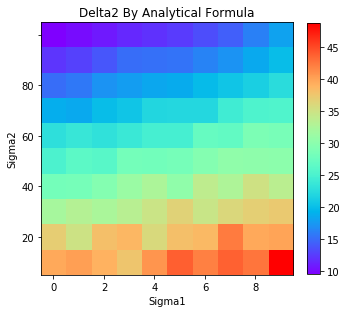

In [35]:
fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(McPrices, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Pricing By Monte Carlo", xlabel = "Sigma1", ylabel = "Sigma2")
plt.savefig("McPrices_2")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(AfPrices, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Pricing By Analytical Formula", xlabel = "Sigma1", ylabel = "Sigma2")
plt.savefig("AfPrices_2")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(NDelta1, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta1 By Numerical Methods", xlabel = "Sigma1", ylabel = "Sigma2")
plt.savefig("NDelta1_2")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(NDelta2, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta2 By Numerical Methods", xlabel = "Sigma1", ylabel = "Sigma2")
plt.savefig("NDelta2_2")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(AfDelta1, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta1 By Analytical Formula", xlabel = "Sigma1", ylabel = "Sigma2")
plt.savefig("AfDelta1_2")

fig,ax = plt.subplots(figsize=(5,5))
im = ax.imshow(AfDelta2, cmap='rainbow')
plt.colorbar(im, fraction = 0.045)
ax.set_yticklabels([0, "", 80, 60, 40,20])
ax.set(title = "Delta2 By Analytical Formula", xlabel = "Sigma1", ylabel = "Sigma2")
plt.savefig("AfDelta2_2")

### 3. Extreme cases
### Case 1. Zero correlation, correlation = 0
### Case 2. Perfect correlation, correlation = 1

In [20]:
## Validation process:
### 3. Extreme cases
# reset params, using historical data
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]

K1, K2 = df['First'][0],df['Second'][0]
r = 0.0083

df_test1 = df.copy()
df_test2 = df.copy()

### case1. zero correlation, correlation = 0
df_test1["rho"] = 0
for index, row in df_test1.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao 
    rho = row.rho
    df_test1.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test1.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test1.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
     
### case2. perfect correlation, correlation = 1
df_test2["rho"] = 0.99 # when rho = 1, formula divide by 0, and we get NaN, so try 0.99 here 
for index, row in df_test2.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao
    rho = row.rho
    df_test2.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test2.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test2.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    


D:\Coding\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


In [21]:
df_test1.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,rho
Date,,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,6.351866,0.138233,0.202095,0
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,6.506398,0.141150,0.204799,0
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,6.032042,0.142100,0.191900,0
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,5.895573,0.141194,0.188996,0
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,5.906352,0.139343,0.190661,0


In [22]:
df_test2.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,rho
Date,,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,18.275267,0.530100,0.515126,0.99
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,18.607971,0.557782,0.516585,0.99
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,18.093454,0.680801,0.495948,0.99
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,17.850428,0.690245,0.491931,0.99
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,17.721354,0.640717,0.496008,0.99


### Case3. S1 << K1

In [23]:
### 3. S1 << K1
df_test3 = df.copy()
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]
K1 = 1000

for index, row in df_test3.iterrows():
    S1 = row.First
    S2 = row.Second
    tao = row.tao 
    #rho = row.rho
    df_test3.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test3.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test3.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)


In [24]:
df_test3.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2
Date,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,0.009175,0.000726,0.000176
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,0.009179,0.000727,0.000174
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,0.007283,0.000615,0.000139
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,0.006802,0.000582,0.000130
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,0.006874,0.000583,0.000132


### Case4. S1 >> K1

In [25]:
### 4. S1 >> K1
df_test4 = df.copy()
df_test4['VanillaOptionPrice'] = 0
df_test4['VanillaOptionDelta2'] = 0
rho = np.corrcoef(df.firlogret[1:], df.seclogret[1:])[0][1]
K1 = 5 

def Pricing_Vanilla_Call(S,K,sigma,T,r):
    d1 = (math.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*math.sqrt(T))
    d2 = d1-sigma*math.sqrt(T)
    C = S*stats.norm.cdf(d1,0,1)- np.exp(-r*T)*K*stats.norm.cdf(d2,0,1)
    return C,stats.norm.cdf(d1,0,1)

for index, row in df_test4.iterrows():
    S1 = row.First  
    S2 = row.Second
    tao = row.tao 
    #rho = row.rho
    df_test4.loc[index,'VanillaOptionPrice'] = Pricing_Vanilla_Call(S2,K2,sigma2,tao,r)[0]  
    df_test4.loc[index,'VanillaOptionDelta2'] = Pricing_Vanilla_Call(S2,K2,sigma2,tao,r)[1]  
    df_test4.loc[index,'OptionPrice'] = Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)  
    df_test4.loc[index,'Delta1'] = Delta1 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)
    df_test4.loc[index,'Delta2'] = Delta2 (S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)


In [26]:
df_test4.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,VanillaOptionPrice,VanillaOptionDelta2
Date,,,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,18.814356,0.001330,0.598290,18.831622,0.599159
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,19.192353,0.001330,0.603790,19.209607,0.604651
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,18.851077,0.001585,0.599353,18.870928,0.600348
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,18.616131,0.001592,0.596418,18.635869,0.597414
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,18.407299,0.001469,0.593860,18.425556,0.594789


### 4. Values vs Correlation

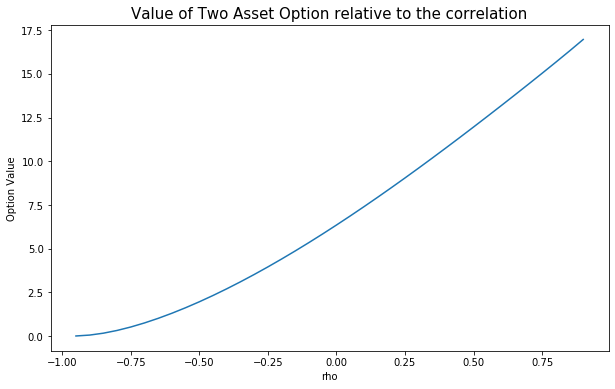

In [27]:
### 4. values vs correlation
def twoassetvalue_rho(rho):
    return Pricing_Correlation_Option(S1, S2, K1, K2, sigma1, sigma2, r, rho, tao)

df_test3 = df.copy()
S1 = df.First[0]
S2 = df.Second[0]
K1 = S1
K2 = S2
tao = 1

x = np.arange(-0.95,0.95, 0.05)
y = []
for i in x:
    y.append(Pricing_Correlation_Option(S1,S2,K1,K2,sigma1,sigma2,r,i,tao))
fig0 = plt.figure(figsize=(10,6))
plt.title("Value of Two Asset Option relative to the correlation",fontsize = 15)
plt.xlabel('rho')
plt.ylabel('Option Value')
plt.plot(x,y)
plt.show()

## BackTest on historical data
## PNL calculation

In [28]:
# BackTest : Pnl calculation
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2
Date,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,10.410965,0.167616,0.296651
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,10.624699,0.170831,0.299488
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,10.042789,0.177025,0.284728
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,9.856477,0.176792,0.281367
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,9.843518,0.173348,0.283304


In [29]:
df['PNL'] = 0
df['PNL_Option'] = df['OptionPrice'] - df['OptionPrice'].shift(1)
df['Price_diff1'] = df['First'] - df['First'].shift(1)
df['Price_diff2'] = df['Second'] - df['Second'].shift(1) 
df['PNL_Hedge'] = df['Delta1'].shift(1) * df['Price_diff1'] + df['Delta2'].shift(1) * df['Price_diff2']
df['PNL'] = df['PNL_Option'] - df['PNL_Hedge']

In [30]:
df.head()

,First,firlogret,Second,seclogret,tao,OptionPrice,Delta1,Delta2,PNL,PNL_Option,Price_diff1,Price_diff2,PNL_Hedge
Date,,,,,,,,,,,,,
2019-05-15,57.930000,NaN,100.199997,NaN,1.000000,10.410965,0.167616,0.296651,NaN,NaN,NaN,NaN,NaN
2019-05-16,58.080002,0.002586,100.889999,0.006863,0.996032,10.624699,0.170831,0.299488,-0.016099,0.213734,0.150002,0.690002,0.229833
2019-05-17,55.480000,-0.045799,100.389999,-0.004968,0.992063,10.042789,0.177025,0.284728,0.011994,-0.581910,-2.600002,-0.500000,-0.593905
2019-05-20,55.009998,-0.008508,100.059998,-0.003293,0.988095,9.856477,0.176792,0.281367,-0.009149,-0.186312,-0.470002,-0.330001,-0.177163
2019-05-21,55.529999,0.009408,99.769997,-0.002902,0.984127,9.843518,0.173348,0.283304,-0.023294,-0.012958,0.520001,-0.290001,0.010335


Text(0.5, 1.0, 'PnL from Option and Hedge Part')

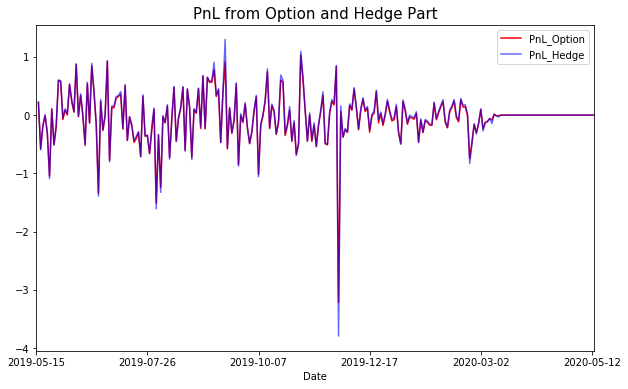

In [31]:
fig1 = plt.figure(figsize=(10,6))
df['PNL_Option'].plot(c='r',label='PnL_Option')
df['PNL_Hedge'].plot(c='b',alpha=0.6,label='PnL_Hedge')
plt.legend()
plt.title("PnL from Option and Hedge Part",fontsize = 15)

Text(0.5, 1.0, 'Total PnL from Hedged Portfolio')

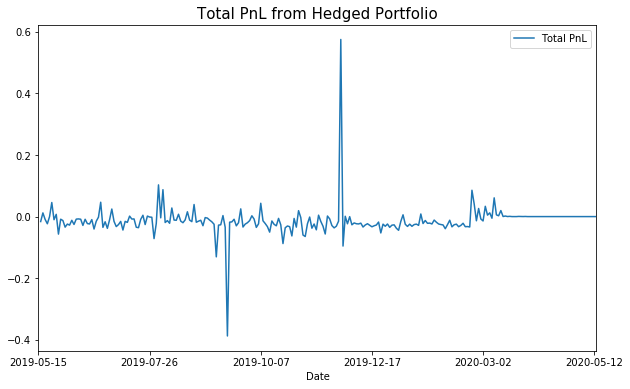

In [32]:
fig2 = plt.figure(figsize=(10,6))
df['PNL'].plot(label='Total PnL')
plt.legend()
plt.title("Total PnL from Hedged Portfolio",fontsize = 15)